<a href="https://colab.research.google.com/github/ME-UoP-ME421/Rankine-LC/blob/main/mechanics/assignments/ME421_Group%20LC_ControlSystems_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instructions

* This is a group assignment. Complete the activities in groups that were assigned for ME421 for the vibrations lab.

* Make a copy of this and save it in your group github group repository.

* Do all your work, EXCLUSIVELY, in that saved notebook. Your github commits will serve as a refelection of your individual contributions. It will constitute 25% of your final grade for the lab.

* Complete all the first 3 tasks by 21/06/2023 and demonstrate the work in the class on 21/06/2023.

* Complete Tasks#1 and Task#2 by 5:00PM on 14/06/2023

* Complete Tasks#3 and the Task#4 by 5:00PM on 21/06/2023 and demonstrate the work in the class on 21/06/2023.

* Complete Task#5 by 5:00PM on 28/06/2023

#References

* https://colab.research.google.com/github/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/Mugas_Rigid_Body_Control.ipynb

* https://github.com/mugalan/classical-mechanics-from-a-geometric-point-of-view/blob/main/rigid-body-control/MaithriPalaDHS_RigidBodyPIDControl_IITB_18_03_2023.pdf

## Setting up Python

In [ ]:
import math
import sympy
import numpy as np
import scipy as sp
from numpy import linalg
from scipy.integrate import odeint
import plotly.graph_objects as go

from sympy import symbols
from sympy import *

from sympy.physics.mechanics import dynamicsymbols, init_vprinting

import plotly.graph_objects as go
import plotly.express as px

In [ ]:
class mugas_rigid_body_functions:

  def __init__(self):
    self=[];

  def simulateDySystem(self, dynamicSystemModel, Tmax, dT, X0, sysPara, figTitle, xLabel, yLabel):
    t = np.linspace(0, Tmax, int(Tmax/dT+1))
    sol = odeint(dynamicSystemModel, X0, t, args=(sysPara,));
    self.soln=sol;
    fig = go.Figure()
    [nt,nS]=sol.shape;

    # Add traces
    for nn in range(nS):
      fig.add_trace(go.Scatter(x=t, y=sol[:,nn], mode='lines+markers', name='x'+str(nn+1)))
      fig.update_layout(title=figTitle, xaxis=dict(title=xLabel),yaxis=dict(title=yLabel))

    fig.show()
    return [t,sol,fig]

  def hatMatrix(self, X):
    return np.array([[0., -X[2], X[1]],[X[2], 0., -X[0]],[-X[1], X[0], 0.]])

  def qFromAxisAngles(self, theta, unitAxis):
    return np.concatenate(([np.cos(theta/2)],np.sin(theta/2)*np.array(unitAxis)))

  def RfromQuaternions(self,q):
    q0=q[0]; w=q[1:];
    R=np.identity(3)+2*q0*self.hatMatrix(w)+2*self.hatMatrix(w) @ self.hatMatrix(w);
    return R

  def rotationMatrix2EulerAngles(self,R):
    if R[2,2] <1:
      if R[2,2] > -1:
        theta2=math.acos(R[2,2]);
        theta1=math.atan2(R[0,2],R[1,2]);
        theta3=math.atan2(R[2,0],-R[2,1]);
      else: #R[2,2]=-1 No Unique solution
        theta2=np.pi;
        theta1=-math.atan2(R[0,1],-R[0,0]);
        theta3=0;
    else: # R[2,2] = +1 No Unique solution
      theta2 = 0;
      theta1 = math.atan2(R[0,1],R[0,0]) ;
      theta3 = 0;
    return [np.pi-theta1,theta2,np.pi-theta3]

  def Re3equalsgamma(self,gamma):
    theta=math.acos(gamma[2]);
    n1=-gamma[1]/np.sin(theta);
    n2=gamma[0]/np.sin(theta);
    q00=self.qFromAxisAngles(theta,[n1,n2,0]);

    return self.RfromQuaternions(q00)

  def rotate_and_translate(self,objectVertices,R,b):
    #object vertices should be given as an numpy array of shape (3,n)
    #Ex - X=[0, 0, 2, 2, 0, 0, 2, 2], Y=[0, 2, 2, 0, 0, 2, 2, 0], Z=[0, 0, 0, 0, 1, 1, 1, 1]; objectVertices=[X,Y,Z]
    return np.array([[b[0],b[1],b[2]]]).T + R @ objectVertices



  def addOrthNormFrame(self, fig, o, R, axisRange, axisColor):
    e1=[1,0,0]; e2=[0,1,0]; e3=[0,0,1];
    b1=R @ e1; b2=R @ e2; b3=R @ e3;
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b1[0])], y=[str(o[1]),str(o[1]+b1[1])], z=[str(o[2]),str(o[2]+b1[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b2[0])], y=[str(o[1]),str(o[1]+b2[1])], z=[str(o[2]),str(o[2]+b2[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.add_trace(go.Scatter3d(x=[str(o[0]),str(o[0]+b3[0])], y=[str(o[1]),str(o[1]+b3[1])], z=[str(o[2]),str(o[2]+b3[2])], hoverinfo='x+y+z', mode='lines', line=dict(width=8, color=axisColor)))
    fig.update_layout(showlegend=False, scene=dict(xaxis=dict(range=axisRange[0], autorange=False), yaxis=dict(range=axisRange[1], autorange=False), zaxis=dict(range=axisRange[2], autorange=False), aspectratio=dict(x=1, y=1, z=1)))
    return fig

  def cube_vertices(self,cubeDimensions):
    l=cubeDimensions['l']; w=cubeDimensions['w']; h=cubeDimensions['h'];
    xp=cubeDimensions['xp']; yp=cubeDimensions['yp']; zp=cubeDimensions['zp'];
    #X=[0, 0, l, l, 0, 0, l, l]; Y=[0, w, w, 0, 0, w, w, 0]; Z=[0, 0, 0, 0, h, h, h, h]; XX=[X,Y,Z];
    X=[-xp, -xp, l-xp, l-xp, -xp, -xp, l-xp, l-xp]; Y=[-yp, w-yp, w-yp, -yp, -yp, w-yp, w-yp, -yp]; Z=[-zp, -zp, -zp, -zp, h-zp, h-zp, h-zp, h-zp]; XX=[X,Y,Z];
    #X=[-l, -l, l, l, -l, -l, l, l]; Y=[-w, w, w, -w, -w, w, w, -w]; Z=[-h, -h, -h, -h, h, h, h, h]; XX=[X,Y,Z];
    return XX


  def animate_particle_motion(self, XX, axisRange, figTitle):
    xx=[jj[0] for jj in XX]
    yy=[jj[1] for jj in XX]
    zz=[jj[2] for jj in XX]

    fig = go.Figure(
        data=[go.Scatter3d(x=[xx[0]], y=[yy[0]],z=[zz[0]],
                        mode="markers",
                        marker=dict(color="red", size=10)),
              go.Scatter3d(x=xx, y=yy,z=zz, name='Path',
                        mode="lines",
                        line=dict(color="blue", width=2))],
        layout=go.Layout(
            scene = dict(
                        xaxis=dict(range=axisRange[0], autorange=False),
                        yaxis=dict(range=axisRange[1], autorange=False),
                        zaxis=dict(range=axisRange[2], autorange=False),
                        aspectratio=dict(x=1, y=1, z=1),
            ),
            title_text=figTitle, hovermode="closest",
            updatemenus=[dict(type="buttons",
                              buttons=[dict(label="Play",
                                            method="animate",
                                            args=[None])])]),
        frames=[go.Frame(
            data=[go.Scatter3d(
                x=[p[0]],
                y=[p[1]],
                z=[p[2]],
                name='Particle',
                mode="markers",
                marker=dict(color="red", size=10))])

            for p in XX]
    )

    fig.show()
    return fig

  def animated_cube_flat_shading(self, cubeVertices,figTitle):
    fig = go.Figure(
        frames=[go.Frame(data=[
          go.Mesh3d(
            # 8 vertices of a cube
            x=xx[0][0],
            y=xx[0][1],
            z=xx[0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)]) for xx in cubeVertices])

    fig.add_trace(go.Mesh3d(
            # 8 vertices of a cube
            x=cubeVertices[0][0][0],
            y=cubeVertices[0][0][1],
            z=cubeVertices[0][0][2],
            # i, j and k give the vertices of triangles
            i = [7, 0, 0, 0, 4, 4, 6, 6, 4, 0, 3, 2],
            j = [3, 4, 1, 2, 5, 6, 5, 2, 0, 1, 6, 3],
            k = [0, 7, 2, 3, 6, 7, 1, 1, 5, 5, 7, 6],
            name='y',
            opacity=0.6,
            color='#DC143C',
            flatshading = True)
        )
    duration=10;
    fig.update_layout(
          title=figTitle,
          width=1200,
          height=1200,
          scene=dict(
                      xaxis=dict(range=[-5., 10.], autorange=False),
                      yaxis=dict(range=[-5., 10.], autorange=False),
                      zaxis=dict(range=[-5., 10.], autorange=False),
                      aspectratio=dict(x=1, y=1, z=1),
                      ),
          updatemenus=[
    dict(
        type="buttons",
        buttons=[
            dict(
                label="Play",
                method="animate",
                args=[
                    None,
                    {
                        "frame": {"duration": duration},
                        "mode": "immediate",
                        "fromcurrent": True,
                        "transition": {"duration": duration, "easing": "linear"},
                    }
                ]
            ),
            dict(
                label="Pause",
                method="animate",
                args=[
                    None,
                    {
                        "frame": {"duration": 0},
                        "mode": "immediate",
                        "fromcurrent": True,
                        "transition": {"duration": 0},
                    }
                ]
            )
        ]
    )
])
    len(fig.frames)
    fig.show()
    return fig

  def simulating_a_cube(self, dt, Tmax, cubeDimensions, parameters,ICs):
    XX=self.cube_vertices(cubeDimensions);

    #Xs=self.eulers_method(dt,Tmax,parameters,ICs);
    Xs=self.runga_kutta_method(dt,Tmax,parameters,ICs);
    ICR=ICs[0][0];
    XX0=ICR @ XX;

    rotatedVertices=[[XX0]]
    for X in Xs:
      #print(X[0])
      R=X[0][0];
      o=X[0][1];
      XXi=self.rotate_and_translate(XX,R,o);
      XX0=XXi;
      rotatedVertices+=[[XX0]];
    return rotatedVertices


  def eulers_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      [taue,fe]=externalForceModel(self, parameters,X);
      [taua,fa]=actuator(self, parameters, t, X,taue,fe);

      dspi=taue+taua;
      dp=fe+fa;
      #dXc=controller_dynamics(self, t,X,taue,fe,parameters)

      if linalg.norm(omega)>=0.0001:
        nomega=omega/linalg.norm(omega);
        thetaomegat=dt*linalg.norm(omega);
      else:
        nomega=np.array([0,0,0]);
        thetaomegat=0;
      qomegat=np.concatenate(([np.cos(thetaomegat/2)],np.sin(thetaomegat/2)*nomega));
      R=self.RfromQuaternions(qomegat) @ R;
      o=o+dt*doto;
      spi=spi+dt*dspi;
      p=p+dt*dp;
      doto=p/M;
      omega=R @ invII @ R.T @ spi;
      Xc=Xc#+dt*dXc;
      X=[[R,o],omega,doto, Xc];
      Xout+=[X]

    return Xout

  def runga_kutta_method(self, dt,Tmax,parameters,ICs):
    M=parameters['M']; II=parameters['II'];
    invII=linalg.inv(II) ;
    timeSteps=np.arange(0,Tmax+dt,dt);
    R=ICs[0][0]; o=ICs[0][1];
    omega=ICs[1]; doto=ICs[2]; Xc=ICs[3];
    X=ICs;
    spi=R@II@R.T@omega; p=M*doto;
    Xout=[X];
    for t in timeSteps:
      Y1=self.rk4_function(0.5*dt, X, t, X, parameters);
      Y2=self.rk4_function(0.5*dt, X, t+0.5*dt, Y1, parameters);
      Y3=self.rk4_function(dt, X, t+0.5*dt, Y2, parameters);

      [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, t, X);
      [thetaomega2,nomega2,doto2,dp2,dspi2,dXc2]=self.rigid_body_system(parameters, t+0.5*dt, Y1);
      [thetaomega3,nomega3,doto3,dp3,dspi3,dXc3]=self.rigid_body_system(parameters, t+0.5*dt, Y2);
      [thetaomega4,nomega4,doto4,dp4,dspi4,dXc4]=self.rigid_body_system(parameters, t+dt, Y3);
      omegak=(dt/6.0)*(thetaomega1*nomega1+2*thetaomega2*nomega2+2*thetaomega3*nomega3+thetaomega4*nomega4)
      if linalg.norm(omegak)>=0.0001:
        nomegak=omegak/linalg.norm(omegak);
        thetaomegak=linalg.norm(omegak);
      else:
        nomegak=np.array([0,0,0]);
        thetaomegak=0;
      qomegak=np.concatenate(([np.cos(thetaomegak/2)],np.sin(thetaomegak/2)*nomegak));
      Rk=self.RfromQuaternions(qomegak) @ X[0][0];

      dotoko=(dt/6.0)*(doto1+2*doto2+2*doto3+doto4);
      dpk=(dt/6.0)*(dp1+2*dp2+2*dp3+dp4);
      dspik=(dt/6.0)*(dspi1+2*dspi2+2*dspi3+dspi4);
      dXck=(dt/6.0)*(dXc1+2*dXc2+2*dXc3+dXc4);

      ok=X[0][1]+dotoko;
      spik=X[0][0]@II@X[0][0].T@X[1]+dspik;
      dotok=X[2]+dpk/M;
      Xck=X[3]+dXck;
      omegak=Rk @ linalg.inv(II) @ Rk.T @ spik;

      X=[[Rk,ok],omegak,dotok,Xck];
      Xout+=[X]
    return Xout

  def rk4_function(self, dtk, X, tk, Xk, parameters):
    M=parameters['M']; II=parameters['II'];
    [thetaomega1,nomega1,doto1,dp1,dspi1,dXc1]=self.rigid_body_system(parameters, tk, Xk)
    qomega1=np.concatenate(([np.cos(dtk*thetaomega1/2)],np.sin(dtk*thetaomega1/2)*nomega1));
    R1=self.RfromQuaternions(qomega1)@X[0][0];
    spi1=X[0][0]@II@X[0][0].T@X[1]+dtk*dspi1; omega1=R1@linalg.inv(parameters['II'])@R1.T@spi1;
    X1=[[R1, X[0][1]+dtk*doto1],omega1,X[2]+dtk*dp1/M, X[3]+dtk*dXc1]
    return X1

  def rigid_body_system(self, parameters, t, X):
    [taue,fe]=externalForceModel(self, parameters,X);
    [taua,fa]=actuator(self, parameters, t, X,taue,fe);
    dspi=taue+taua;
    dp=fe+fa;
    dXc=np.array([0,0,0]); #controller_dynamics(self,t,X,taue,fe,parameters)
    omega=X[1]; doto=X[2]
    if linalg.norm(omega)>=0.0001:
      nomega=omega/linalg.norm(omega);
      thetaomega=linalg.norm(omega);
    else:
      nomega=np.array([0,0,0]);
      thetaomega=0;
    return [thetaomega,nomega,doto,dp,dspi,dXc]

In [ ]:
mr=mugas_rigid_body_functions()

#Task#1

Conside a rigid body moving in space. Let $\mathbf{b}$ be a body fixed frame with the origin coinciding with that of the center of mass of the body, $M$ be the tatal mass of the body, $\mathbb{I}$ be the inertia tensor of the body with respect to the body frame $\mathbf{b}$, $f^e$ be the resultant total external interactions acting on the particles of the body, and $\tau^e$ be the total resultant of the moments of the external interactions about the center of mass of the body.

Show that a general rigid body is descibed by the following simple equations in an inertial frame $\mathbf{e}$ where the moments are taken about the center of mass of the rigid body.

\begin{align}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e+f^u,\\
\dot{\pi}&=\tau^e+\tau^u,
\end{align}
where
\begin{align}
\omega &=(\mathbb{I}_c^R)^{-1}\pi,
\end{align}
Here we have split the force and control moments into unmanipulatable and manipulatable (control) part. The manipulatable (control) part will be denoted by a superscript $u$.

#Task#1

Conside a rigid body moving in space. Let $\mathbf{b}$ be a body fixed frame with the origin coinciding with that of the center of mass of the body, $M$ be the tatal mass of the body, $\mathbb{I}$ be the inertia tensor of the body with respect to the body frame $\mathbf{b}$, $f^e$ be the resultant total external interactions acting on the particles of the body, and $\tau^e$ be the total resultant of the moments of the external interactions about the center of mass of the body.

Show that a general rigid body is descibed by the following simple equations in an inertial frame $\mathbf{e}$ where the moments are taken about the center of mass of the rigid body.

\begin{align}
\dot{o}&=\frac{1}{M}p\\
\dot{R}&=\widehat{\omega}R,\\
\dot{p}&=f^e+f^u,\\
\dot{\pi}&=\tau^e+\tau^u,
\end{align}
where
\begin{align}
\omega &=(\mathbb{I}_c^R)^{-1}\pi,
\end{align}
Here we have split the force and control moments into unmanipulatable and manipulatable (control) part. The manipulatable (control) part will be denoted by a superscript $u$.

$\dot{o}=\frac{1}{M}p$......................(1)


Let's derive the equation **$\dot{o} = \frac{1}{M}p$** for the translation of the center of mass using basic principles of mechanics.

We start with Newton's second law, which states that the rate of change of momentum of an object is equal to the net force acting on it. In vector form, this law can be expressed as:
\begin{equation}
\frac{d\mathbf{p}}{dt} = \sum \mathbf{F},
\end{equation}

where $\frac{d\mathbf{p}}{dt}$ is the derivative of the momentum vector $\mathbf{p}$ with respect to time, and $\sum \mathbf{F}$ represents the sum of all external forces acting on the body.

For a rigid body, the total linear momentum $\mathbf{p}$ is the sum of the linear momenta of all particles in the body. Mathematically, it can be written as:
\begin{equation}
\mathbf{p} = \sum m_i \mathbf{v}_i,
\end{equation}

where $m_i$ is the mass of the $i$-th particle, and $\mathbf{v}_i$ is its velocity.

The center of mass of a rigid body can be defined as the weighted average of the positions of all particles, where the weights are given by the masses of the particles. Mathematically, it can be expressed as:
\begin{equation}
\mathbf{o} = \frac{1}{M} \sum m_i \mathbf{r}_i,
\end{equation}

where $\mathbf{o}$ is the position vector of the center of mass, $\mathbf{r}_i$ is the position vector of the $i$-th particle, and $M$ is the total mass of the body, given by $M = \sum m_i$.

Now, let's differentiate the equation for the center of mass position with respect to time to find its rate of change:
\begin{align}
\dot{\mathbf{o}} &= \frac{d}{dt} \left( \frac{1}{M} \sum m_i \mathbf{r}_i \right)
= \frac{1}{M} \sum m_i \frac{d\mathbf{r}_i}{dt}
= \frac{1}{M} \sum m_i \mathbf{v}_i
= \frac{1}{M} \mathbf{p}.
\end{align}

In the third step, we used the fact that the derivative of the position vector with respect to time gives the velocity vector, so $\frac{d\mathbf{r}_i}{dt} = \mathbf{v}_i$.

Thus, we have derived the equation $\dot{\mathbf{o}} = \frac{1}{M} \mathbf{p}$, which shows that the rate of change of the center of mass position is equal to the total linear momentum divided by the total mass of the body.

$\dot{R}=\widehat{\omega}R$......................(2)

 Let's derive the equation $\dot{R} = \widehat{\omega}R$ for the rotational motion of a rigid body using basic principles of rotational kinematics.

Consider a rigid body rotating in three-dimensional space. The orientation of the body can be represented by a rotation matrix $R$. This matrix maps coordinates from the body-fixed frame to the inertial frame.

The angular velocity vector $\boldsymbol{\omega}$ describes the rate at which the body is rotating. It is a vector that points along the axis of rotation, and its magnitude represents the angular speed of rotation.

The time derivative of the rotation matrix $R$ represents the rate of change of the orientation of the body. We can express this derivative as $\dot{R}$.

The relationship between the angular velocity $\boldsymbol{\omega}$ and the derivative of the rotation matrix $\dot{R}$ is given by the formula:

\begin{equation}
\dot{R} = \widehat{\boldsymbol{\omega}} R,
\end{equation}

where $\widehat{\boldsymbol{\omega}}$ is the skew-symmetric matrix representation of the angular velocity vector $\boldsymbol{\omega}$.

Now, let's go through the derivation:

Consider a point $P$ fixed in the body frame. Its position vector in the inertial frame can be expressed as $\mathbf{r} = R \mathbf{r}_0$, where $\mathbf{r}_0$ is the position vector of $P$ in the body-fixed frame.

Take the time derivative of $\mathbf{r}$ to find its rate of change:

\begin{align}
\dot{\mathbf{r}} &= \frac{d}{dt} (R \mathbf{r}_0)
= \dot{R} \mathbf{r}_0.
\end{align}

We also know that the velocity $\mathbf{v}$ of point $P$ is given by the cross product of the angular velocity $\boldsymbol{\omega}$ and its position vector $\mathbf{r}$:
\begin{equation}
\mathbf{v} = \boldsymbol{\omega} \times \mathbf{r}.
\end{equation}

Take the time derivative of $\mathbf{r}$ using the product rule and simplify:
\begin{align}
\dot{\mathbf{r}} = \frac{d}{dt} (R \mathbf{r}_0)
= \dot{R} \mathbf{r}_0
= (\dot{R} \mathbf{r}_0) \times \mathbf{r}
= (\dot{R} \mathbf{r}_0) \times (R \mathbf{r}_0).
\end{align}

Equate the expressions for $\mathbf{v}$ from steps 3 and 4:
\begin{equation}
\boldsymbol{\omega} \times \mathbf{r} = (\dot{R} \mathbf{r}_0) \times (R \mathbf{r}_0).
\end{equation}

Since $\mathbf{r}_0$ is an arbitrary vector, we can cancel it out from both sides of the equation:
\begin{equation}
\boldsymbol{\omega} \times \mathbf{r} = \dot{R} R \mathbf{r}_0.
\end{equation}

Recognize that $\mathbf{r}$ is a general vector in the body frame, so we can write it as $\mathbf{r} = R \mathbf{r}_0$:
\begin{equation}
\boldsymbol{\omega} \times (R \mathbf{r}_0) = \dot{R} R \mathbf{r}_0.
\end{equation}

Multiply both sides by $R^{-1}$ from the right to simplify the equation:
\begin{equation}
\boldsymbol{\omega} \times \mathbf{r}_0 = \dot{R} R.
\end{equation}

Finally, we recognize that $\boldsymbol{\omega} \times \mathbf{r}_0$ is the cross product of $\boldsymbol{\omega}$ with the position vector $\mathbf{r}_0$, which can be expressed as the skew-symmetric matrix $\widehat{\boldsymbol{\omega}}$:
\begin{equation}
\boldsymbol{\omega} \times \mathbf{r}_0 = \widehat{\boldsymbol{\omega}} \mathbf{r}_0.
\end{equation}

Substituting this into the previous equation, we obtain:

\begin{equation}
\widehat{\boldsymbol{\omega}} \mathbf{r}_0 = \dot{R} R.
\end{equation}

This equation relates the derivative of the rotation matrix $\dot{R}$ to the skew-symmetric matrix $\widehat{\boldsymbol{\omega}}$. Thus, we have derived the equation $\dot{R} = \widehat{\boldsymbol{\omega}} R$, which describes the rotational motion of a rigid body.

$\dot{p} = f^e + f^u$ and $\dot{\pi} = \tau^e + \tau^u$......................(2)

Let's derive the equations $\dot{p} = f^e + f^u$ and $\dot{\pi} = \tau^e + \tau^u$ for the forces and moments acting on a rigid body using basic principles of classical mechanics.

**Linear Momentum:**
Newton's second law states that the rate of change of linear momentum is equal to the net force acting on an object. Considering a rigid body, we can express this as:
\begin{equation}
\dot{p} = \sum f,
\end{equation}

where $\dot{p}$ represents the time derivative of linear momentum, and $\sum f$ denotes the sum of all forces acting on the body.

**External and Unmanipulatable Forces:**
In reality, forces acting on a body can come from both external sources and internal sources (such as control forces). To distinguish between these forces, we split the total force into two parts: the resultant external force $f^e$ and the unmanipulatable force $f^u$.
The resultant external force $f^e$ represents the net force exerted on the body by external sources, such as gravity, contact forces, or fluid interactions. These forces cannot be controlled or manipulated directly by the body.

The unmanipulatable force $f^u$ represents forces that arise from internal sources (such as control forces) or external sources that the body can control or manipulate. These forces are typically used to achieve desired motions or control the behavior of the body.

**Angular Momentum:**
Similar to linear momentum, angular momentum is also conserved in the absence of external moments. However, when external moments act on a rigid body, the angular momentum changes. We can express this as:
\begin{equation}
\dot{\pi} = \sum \tau,
\end{equation}

where $\dot{\pi}$ represents the time derivative of angular momentum, and $\sum \tau$ denotes the sum of all moments acting on the body.

**External and Unmanipulatable Moments:**
As with forces, moments acting on the body can come from both external and internal sources. To distinguish between them, we split the total moment into two parts: the resultant external moment $\tau^e$ and the unmanipulatable moment $\tau^u$.
The resultant external moment $\tau^e$ represents the net moment exerted on the body by external sources, such as torque applied by external forces or moments arising from interactions with the environment. These moments cannot be controlled or manipulated directly by the body.

The unmanipulatable moment $\tau^u$ represents moments that arise from internal sources (such as control moments) or external sources that the body can control or manipulate. These moments are typically used to achieve desired rotations or control the orientation of the body.

**Combining External and Unmanipulatable Parts:**
To account for both the external and unmanipulatable forces and moments, we add the respective parts together:
\begin{equation}
\dot{p} = f^e + f^u, \quad \dot{\pi} = \tau^e + \tau^u.
\end{equation}

These equations express the change in linear momentum and angular momentum of a rigid body as the sum of the resultant external interactions ($f^e$ and $\tau^e$) and the unmanipulatable interactions ($f^u$ and $\tau^u$).


#Task#2

Simulate the motion of a quadrotor UAV without resorting any parameterization of $SO(3)$ such as Euler angles or quaternions.

## Answer for task 2


### Eqaution derivation

\begin{align}
\dot{p}&=f^e+f^u,\\
\dot{\pi}&=\tau^e+\tau^u,
\end{align}

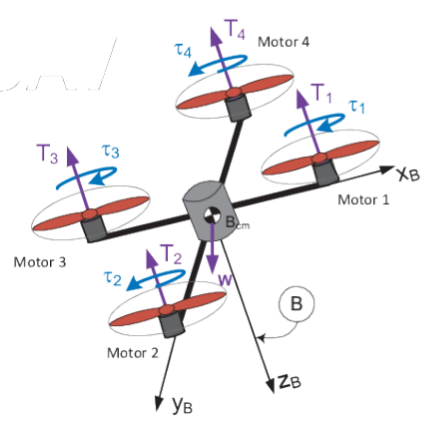

The τ applied to the drone with repect to the body frame by the 4 rotors is represented by the following matrix

\begin{align}
T^u = \begin{bmatrix}0 &l1cl & 0 & -l1cl\\ -l1cl &0&lc1 & 0\\-cd & cd & -cd & cd\end{bmatrix}\begin{bmatrix}\omega_1^2 \\ \omega_2^2 \\ \omega_3^3 \\ \omega_4^4 \end{bmatrix}
\end{align}

The force applied to the rotor by the thrust force on Z direction of the body fixed frame is given by

\begin{align}
f_u=c_1(\omega_1^2 + \omega_2^2+w_3^2+w_4^2)
\end{align}

Mutipling the above froce matrix by the directional matrix γ  its possible to have the force in the Z direction of the body fixed frame.
\begin{align}
γ=\begin{bmatrix}0\\ 0 \\ 1\end{bmatrix}
\end{align}

\begin{align}
F_u =f_u γ
\end{align}


### python code for simulation

In [ ]:
def externalForceModel(qq,parameters,X):
  #Heavy Top Object
  M=parameters['M']; II=parameters['II']; g=parameters['g']; CM=parameters['CM'];
  R=X[0][0]; omega=X[1]; spi=R@ II@ R.T @ omega
  taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1])-0*spi;
  fe=np.array([0,0.,-M*g]);

  return [taue,fe]

def actuator(qq,parameters, t, X, taue,fe):
  #tauu=np.array([0,0,0]);
  #fu=np.array([0,0,0]);
  R=X[0][0];
  l1=1
  cd=0.005
  cl=0.01
  w1=8
  w2=10
  w3=10
  w4=10
  ts=np.array([[0,l1*cl,0,-l1*cl],[-l1*cl,0,l1*cl,0],[-cd,cd,-cd,cd]])
  ip_omega=np.array([[w1*w1],[w2*w2],[w3*w3],[w4*w4]])
  Tauu=ts@ip_omega
  tauu1=(R@Tauu)

  Fu_1=cl*(w1*w1+w2*w2+w3*w3+w4*w4)
  gamma=np.array([[0],[0],[1]])
  Fu=Fu_1*gamma
  fu1 =(R@Fu)
  fu=np.array([fu1[0][0],fu1[1][0],fu1[2][0]])
  tauu=np.array([tauu1[0][0],tauu1[1][0],tauu1[2][0]])


  return [tauu,fu]




In [ ]:
mr=mugas_rigid_body_functions()

In [ ]:
cubeDimensions={'l':2.,'w':2.,'h':0.5,'xp':1.,'yp':1.,'zp':0.25,};
parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['w']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':1, 'M':1, 'II':np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])};
ICq=mr.qFromAxisAngles(0,np.array([1,0,0])); ICR=mr.RfromQuaternions(ICq);
IComega=np.array([0.,0.,0.]); ICo=np.array([0.,0.,0.]); ICp=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICR,ICo],IComega,ICp,ICXC]

### Simulation of the drone

In [ ]:
aa4=mr.simulating_a_cube(0.01, 10., cubeDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(aa4,'Simulatio of the drone')

#Task#3

Deerive a PID controller for the attitude control of a quadrorotor and use simulations to demibstrate the very large region of stability of the controller

Here are few example our own implementations of this controller.

* https://youtu.be/6E9WDQNVSYA
* https://youtu.be/uUKxXImRMOA
* https://youtu.be/zq05N8m_9SA
* https://youtu.be/J5dThZGZN2g
* https://youtu.be/J5MMp6Be3tU
* https://youtu.be/6ZQgE1FI6Wc

## PID Control

###Tracking Error Dynamics

Let $(o(t),R_r(t))$ be a desired trajectory and $\omega_r(t)$ be such that
 $\widehat{\omega}_r(t)=\dot{R}_rR_r^T$.

 In line with the system define the reference spatial linear momentum $p_r\triangleq M\dot{o_r}$ and the spatial angular momentum $\pi_r\triangleq R_r\mathbb{I}R_r^T\omega_r$

Defining the configurarion error,
\begin{align}
o_e&=o_r-o,\\
R_e&=R_rR^T.
\end{align}

Then the spatial angular velcity of the tracking error is defined by
\begin{align}
\widehat{\omega}_e&\triangleq \dot{R}_eR_e^T=\widehat{\omega}_r(t)-R_e\widehat{\omega}(t)R_e^T
\end{align}
and hence that
\begin{align}
\omega_e&=\omega_r-R_e\omega.
\end{align}
Define the angular momentum error as
\begin{align}
\pi_e\triangleq R\mathbb{I}R_r^T\omega_e=R\mathbb{I}R_r^T(\omega_r-R_e\omega)=R\mathbb{I}R_r^T\omega_r-R\mathbb{I}R^T\omega=R_e^T\pi_r-\pi.
\end{align}
Similarly define the linear momentum error,
\begin{align}
 p_e\triangleq p_r-p
\end{align}
Differentiating $\pi_e$,

we have,
\begin{align}
\dot{\pi}_e&=R_e^T(\dot{\pi}_r-\omega_e\times \pi_r)-\dot{\pi}=R_e^T(R_r\dot{\Pi}_r+(\omega_r-\omega_e)\times \pi_r)-\dot{\pi}=(R\dot{\Pi}_r+\omega\times \pi_r)-\dot{\pi}
\end{align}


###Controlled Error Dynamics

\begin{align}
\dot{e}_{I_o}&=e_o,\\
\dot{o}_e&=\frac{1}{M}p_e,\\
\dot{p}_e&=-k_{P_o}e_o-k_{D_o}p_e-k_{I_o}e_{I_o},\\
\dot{e}_{I_R}&=e_R,\\
\dot{R}_e&=\widehat{\omega}_eR_e,\\
\dot{\pi}_e&=-k_{P_R}e_R-k_{D_R}\pi_e-k_{I_R}e_{I_R}
\end{align}

Here \begin{align}
o_e&=o_r-o,\\
R_e&=R_rR^T.
\end{align}
$\widehat{\omega}_r(t)=\dot{R}_rR_r^T$, $p_r\triangleq M\dot{o_r}$, $\pi_r\triangleq R_r\mathbb{I}R_r^T\omega_r$
\begin{align}
\omega_e&=\omega_r-R_e\omega,
\end{align}
\begin{align}
\pi_e\triangleq R\mathbb{I}R_r^T\omega_e,
\end{align}
and $p_e\triangleq p_r-p$.

In the section below we proceed to find the correct proportional control action $(e_o,e_R)$.

In [ ]:
def externalForceModel(qq,parameters,X):
  #Heavy Top Object
  R=X[0][0];
  M=parameters['M']; g=parameters['g']; CM=parameters['CM'];
  fe=np.array([0,0,0]);
  taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1]);
  return [taue,fe]

def actuator(qq,parameters, t, X, taue,fe):
  Uc=controller(qq, parameters, t, X, taue,fe);
  tauu=Uc[0]; fu=Uc[1]
  return [tauu,fu]

In [ ]:
def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=np.array([[1,0,0],[0,1,0],[0,0,1]]);
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  #Fully Actuated PD Controller
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-0.*taue+(4*eR+10*pie+2.*piI) #tauu with PID parts added
  fu=np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;
  return dXc

#Defining the rotational matrix in the 3 axix(x,y,z)
def R_from_h (t1,t2,t3):
  R1=np.array([[1,0,0],[0,np.cos(t1),-np.sin(t1)],[0,np.sin(t1),np.cos(t1)]])
  R2=np.array([[np.cos(t2),0,np.sin(t2)],[0,1,0],[-np.sin(t2),0,np.cos(t2)]])
  R3=np.array([[np.cos(t3),-np.sin(t3),0],[np.sin(t3),np.cos(t3),0],[0,0,1]])
  R_1=R1@R2
  R=R_1@R3
  return R

In [ ]:
cubeDimensions={'l':2.,'w':2.,'h':0.5,'xp':1.,'yp':1.,'zp':0.25,};
parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['w']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':1, 'M':1, 'II':np.array([[1.,0.,0.],[0.,1.,0.],[0.,0.,1.]])};
ICR=R_from_h(np.pi/3,0,0);
IComega=np.array([0.,0.,0.]); ICo=np.array([0.,0.,0.]); ICp=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICR,ICo],IComega,ICp,ICXC]

### Simulation

In [ ]:
aa4=mr.simulating_a_cube(0.1, 1000., cubeDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(aa4,'Fully Actuated Cube Pivoted at a Vertex')

#Task#4

Derive a specialization of the controller develoed in Task#3 for the problem of stabilzing an inverted pendulum on a cart.

### Controlled Error Dynamics

\begin{align}
\dot{e}_{I_o}&=e_o,\\
\dot{o}_e&=\frac{1}{M}p_e,\\
\dot{p}_e&=-k_{P_o}e_o-k_{D_o}p_e-k_{I_o}e_{I_o},\\
\dot{e}_{I_R}&=e_R,\\
\dot{R}_e&=\widehat{\omega}_eR_e,\\
\dot{\pi}_e&=-k_{P_R}e_R-k_{D_R}\pi_e-k_{I_R}e_{I_R}
\end{align}

Here \begin{align}
o_e&=o_r-o,\\
R_e&=R_rR^T.
\end{align}
$\widehat{\omega}_r(t)=\dot{R}_rR_r^T$, $p_r\triangleq M\dot{o_r}$, $\pi_r\triangleq R_r\mathbb{I}R_r^T\omega_r$
\begin{align}
\omega_e&=\omega_r-R_e\omega,
\end{align}
\begin{align}
\pi_e\triangleq R\mathbb{I}R_r^T\omega_e,
\end{align}
and $p_e\triangleq p_r-p$.

In the section below we proceed to find the correct proportional control action $(e_o,e_R)$.

In [ ]:
def externalForceModel(qq,parameters,X):
  #Heavy Top Object
  R=X[0][0];
  M=parameters['M']; g=parameters['g']; CM=parameters['CM'];
  fe=np.array([0,0,0]);
  taue=(-M*g*qq.hatMatrix(R@CM) @ [0,0,1]);
  return [taue,fe]

def actuator(qq,parameters, t, X, taue,fe):
  Uc=controller(qq, parameters, t, X, taue,fe);
  tauu=Uc[0]; fu=Uc[1]
  return [tauu,fu]

In [ ]:
def referenceConfig(qq,refParameters,t):
  II=refParameters;
  dotOmegart=np.array([0,.01,0]);
  dotPir=II@dotOmegart;
  Omegart=np.array([0,0,0])+dotOmegart*t;
  Pir=II@Omegart;
  thetaOmegart=linalg.norm(Omegart)*t+0*np.pi;
  nOmegart=Omegart/(0.000001+linalg.norm(Omegart));
  qOmegart=np.concatenate(([np.cos(thetaOmegart/2)],np.sin(thetaOmegart/2)*nOmegart));
  Rr=np.array([[1,0,0],[0,1,0],[0,0,1]]);
  return [Rr,Pir,dotPir]

def controller(qq,parameters,t,X,taue,fe):
  #Fully Actuated PD Controller
  II=parameters['II'];
  R=X[0][0]; omega=X[1]; piI=X[3];
  [Rr,Pir,dotPir]=referenceConfig(qq,II,t);
  pir=Rr@Pir;
  omegar=Rr@linalg.inv(II)@Pir;
  Re=Rr@R.T;
  pie=R @ II @ Rr.T @ (omegar-Re@omega);
  K=np.array([[1,0,0],[0,2,0],[0,0,3]]);
  eRhat=0.5*(Re@K-K@Re.T);
  eR=np.array([-eRhat[1,2],eRhat[0,2],-eRhat[0,1]]);
  tauu=(R@dotPir+qq.hatMatrix(omega)@pir)-1.*taue+(4*eR+10*pie+2.*piI) #tauu with PID parts added
  fu=np.array([0,0,0]);
  return [tauu,fu,eR,pie]

def controller_dynamics(qq, t,X,taue,fe,parameters):
  Xc=X[3];
  Uc=controller(qq,parameters,t,X,taue,fe);
  eR=Uc[2];
  dXc=eR;
  return dXc

#Defining the rotational matrix in the 3 axix(x,y,z)
def R_from_h (t1,t2,t3):
  R1=np.array([[1,0,0],[0,np.cos(t1),-np.sin(t1)],[0,np.sin(t1),np.cos(t1)]])
  R2=np.array([[np.cos(t2),0,np.sin(t2)],[0,1,0],[-np.sin(t2),0,np.cos(t2)]])
  R3=np.array([[np.cos(t3),-np.sin(t3),0],[np.sin(t3),np.cos(t3),0],[0,0,1]])
  R_1=R1@R2
  R=R_1@R3
  return R

In [ ]:

cubeDimensions={'l':1,'w':1,'h':3,'xp':1/2,'yp':1/2,'zp':0,};
parameters={'CM':np.array([cubeDimensions['l']/2-cubeDimensions['xp'],cubeDimensions['w']/2-cubeDimensions['yp'],cubeDimensions['h']/2-cubeDimensions['zp']]), 'g':9.81, 'M':0.2, 'II':np.array([[(1/12)*((cubeDimensions['l']**2)+(cubeDimensions['w']**2)),0.,0.],[0.,1/12*((cubeDimensions['w']**2)+(cubeDimensions['h']**2)),0.],[0.,0.,(1/12)*(cubeDimensions['h']**2+cubeDimensions['l']**2)]])};
ICI=R_from_h(np.pi/2,0,0);
IComega=np.array([0.,0.,0.]); ICo=np.array([0.,0.,0.]); ICp=np.array([0.,0.,0.]);
ICXC=np.array([0,0,0]);
ICs=[[ICI,ICo],IComega,ICp,ICXC]

### Simulation

In [ ]:
aa4=mr.simulating_a_cube(0.1, 100., cubeDimensions, parameters,ICs)
fig1=mr.animated_cube_flat_shading(aa4,'inverted pendulam with cart')

#Task#5

 Experimentally verify the stability properties of the controller derived in Task#5 using the experimental setup available in the applied mechanics lab.